In [13]:
!pip install -q torch torchvision torchaudio
!pip install -q transformers datasets tqdm scikit-learn

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_scheduler
)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

In [15]:
df = pd.read_csv("urdu_sentiment_data.csv")
print(" Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())

 Dataset loaded successfully!
Shape: (10000, 2)
                                              review sentiment
0  یہ بے گھر خواتین کے بارے میں ایک دستاویزی فلم ...  negative
1  بالکل بھی اچھ ،ی کام نہیں کیا گیا ، پوری فلم ص...  negative
2  یہ عجیب بات ہے کہ کچھ لوگوں کا کیا حشر ہوتا ہے...  negative
3  اور یہ خاص طور پر وکیلوں اور پولیس اہلکاروں کے...  positive
4  پہلے ، ایک وضاحت: میری سرخی کے باوجود ، میں اس...  positive


In [16]:
def clean_urdu_text(text):
    if not isinstance(text, str):
        return ""

    # Remove English letters and numbers
    text = re.sub(r"[a-zA-Z0-9]", "", text)

    # Remove punctuation and symbols
    text = re.sub(r"[^\w\s\u0600-\u06FF]", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [17]:
df['review'] = df['review'].astype(str)
df['cleaned_review'] = df['review'].apply(clean_urdu_text)

In [18]:
df['sentiment'] = df['sentiment'].astype(str).str.strip().str.title()

sentiment_map = {
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
}

df['sentiment'] = df['sentiment'].map(sentiment_map)

In [19]:
df = df.dropna(subset=['sentiment'])
print("Cleaned dataset shape:", df.shape)

Cleaned dataset shape: (10000, 3)


In [20]:
print("\n Sentiment Class Counts:")
print(df['sentiment'].value_counts())


 Sentiment Class Counts:
sentiment
3    5082
1    4918
Name: count, dtype: int64


In [21]:
X = df['cleaned_review']
y = df['sentiment']

if len(df) > 5:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\n Split Successful:")
    print(f"Training Samples: {len(X_train)}")
    print(f"Testing Samples : {len(X_test)}")
else:
    print("Not enough samples to split — please add more data.")


 Split Successful:
Training Samples: 8000
Testing Samples : 2000


In [22]:
df[['cleaned_review', 'sentiment']].to_csv("urdu_cleaned_dataset.csv", index=False)
print("\n Cleaned data saved as 'urdu_cleaned_dataset.csv'")


 Cleaned data saved as 'urdu_cleaned_dataset.csv'


In [38]:
df = pd.read_csv("urdu_cleaned_dataset.csv")
# If you fixed labels earlier, confirm they are 0/1:
print("Unique labels:", sorted(df['sentiment'].unique()))
print("Total rows:", len(df))
# Drop any bad rows
df = df.dropna(subset=['cleaned_review', 'sentiment'])
df['sentiment'] = df['sentiment'].astype(int)

Unique labels: [np.int64(1), np.int64(3)]
Total rows: 10000


In [40]:
VOCAB_SIZE = 8000
MAX_LEN = 120

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=None)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN)

# convert labels to numpy arrays and ensure shapes match
y_train = np.array(y_train)
y_test  = np.array(y_test)

print("X_train_pad shape:", X_train_pad.shape)
print("y_train shape     :", y_train.shape)
print("X_test_pad shape :", X_test_pad.shape)
print("y_test shape      :", y_test.shape)

X_train_pad shape: (8000, 120)
y_train shape     : (8000,)
X_test_pad shape : (2000, 120)
y_test shape      : (2000,)


In [41]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved.")


Tokenizer saved.


📊 SVM Results:

              precision    recall  f1-score   support

           0     0.8586    0.8516    0.8551       984
           1     0.8574    0.8642    0.8608      1016

    accuracy                         0.8580      2000
   macro avg     0.8580    0.8579    0.8579      2000
weighted avg     0.8580    0.8580    0.8580      2000



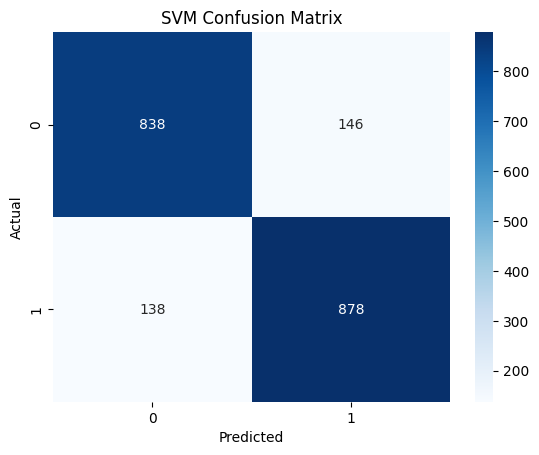

In [26]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf  = tfidf.transform(X_test).toarray()

svm_model = svm.LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("📊 SVM Results:\n")
print(classification_report(y_test, y_pred_svm, digits=4))

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

vocab_size = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)

model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# build & compile (build optional if you want to call summary)
model_bilstm.build(input_shape=(None, MAX_LEN))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()


C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 120, 64)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,889 (2.05 MB)

 Trainable params: 537,889 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history_bilstm = model_bilstm.fit(
    X_train_pad,
    y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.4890 - loss: -42.6350 - val_accuracy: 0.5063 - val_loss: -102.2455
Epoch 2/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4901 - loss: -205.2489 - val_accuracy: 0.5063 - val_loss: -316.8608
Epoch 3/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.4901 - loss: -500.1260 - val_accuracy: 0.5063 - val_loss: -679.7949


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
              precision    recall  f1-score   support

           1     0.4920    1.0000    0.6595       984
           3     0.0000    0.0000    0.0000      1016

    accuracy                         0.4920      2000
   macro avg     0.2460    0.5000    0.3298      2000
weighted avg     0.2421    0.4920    0.3245      2000



C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classifica

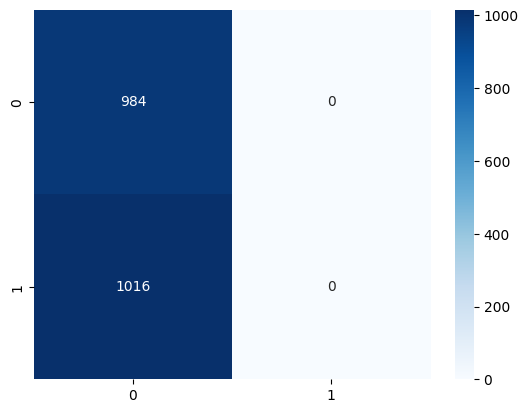

Saved bilstm_urdu_sentiment_model.h5


In [44]:
y_pred_prob = model_bilstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred, digits=4))

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

# save model
model_bilstm.save("bilstm_urdu_sentiment_model.h5")
print("Saved bilstm_urdu_sentiment_model.h5")